# Forecasting - Facebook Prophet

In [5]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
mpl.rcParams['figure.figsize'] = (16, 10)
pd.set_option('display.max_rows', 500)

import plotly.graph_objects as go

In [4]:
#from fbprophet import Prophet 

In [6]:
%matplotlib inline
plt.style.use('fivethirtyeight')

In [ ]:
#def mean_absolute_percentage_error(y_true, y_pred): 
   # y_true, y_pred = np.array(y_true), np.array(y_pred)
   # return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

## Trivial Forecast (rolling mean)

In [6]:
df = pd.DataFrame({'X': np.arange(0,10)}) # generate an input df
df['y']=df.rolling(3).mean()
df

,X,y
0,0,NaN
1,1,NaN
2,2,1.0
3,3,2.0
4,4,3.0
5,5,4.0
6,6,5.0
7,7,6.0
8,8,7.0
9,9,8.0


In [11]:
#trying over small data set first
df_new = pd.read_csv('../data/processed/COVID_small_flat_table.csv',sep=';')
df=df_new[['date','India']]
df=df.rename(columns={'date': 'ds',
                        'India': 'y'})

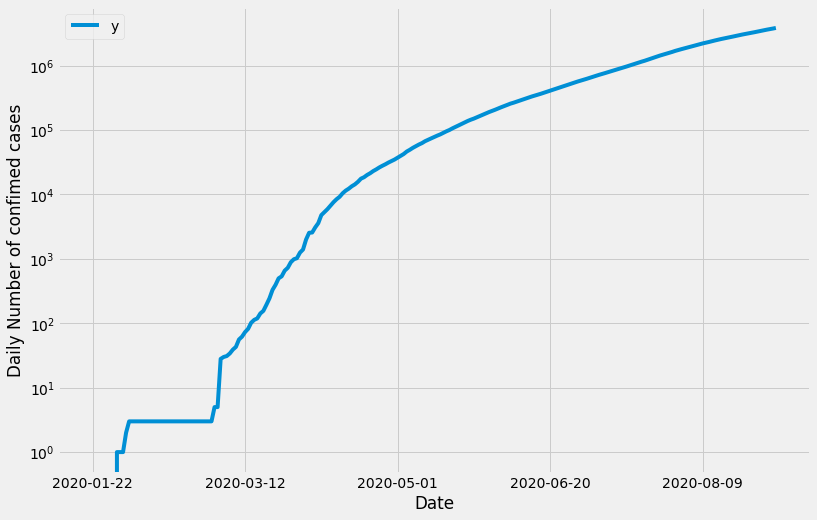

In [12]:
ax = df.set_index('ds').plot(figsize=(12, 8),
                             logy=True)
ax.set_ylabel('Daily Number of confimed cases')
ax.set_xlabel('Date')

plt.show()


In [14]:
my_model = Prophet(interval_width=0.95)   #changing uncertainty interval to 95% 
#my_model = Prophet(growth='logistic')

NameError: name 'Prophet' is not defined

In [ ]:
#df['cap']=1000000
my_model.fit(df)

In [13]:
#adding more date vectors (to predict) to the existing dataframe
future_dates = my_model.make_future_dataframe(periods=7, freq='D')
#future_dates['cap']=1000000. # only mandatory for the logistic model
future_dates.tail()

NameError: name 'my_model' is not defined

In [ ]:
forecast = my_model.predict(future_dates)

In [ ]:
my_model.plot(forecast,uncertainty=True ); 

In [ ]:
#plotting the same in plotly to overcome fbprophet rendering drawbank
import plotly.offline as py
from fbprophet.plot import plot_plotly

fig = plot_plotly(my_model, forecast) 

fig.update_layout(
    width=1024,
    height=900,
    xaxis_title="Time",
    yaxis_title="Confirmed infected people (source johns hopkins csse, log-scale)",
)
fig.update_yaxes(type="log",range=[1.1,5.5])
py.iplot(fig)

In [ ]:
forecast.sort_values(by='ds').head() #checking what information we get from this prediction model

In [ ]:
my_model.plot_components(forecast); #decomsing the prediction model for treand and seasonal pattern

In [ ]:
#to get better visualization of the trend, plotting the graph from the data frame data directly
forecast[['ds','trend']].set_index('ds').plot(figsize=(12, 8),logy=True)

## Cross Validation

In [ ]:
from fbprophet.diagnostics import cross_validation
df_cv = cross_validation(my_model, 
                         initial='40 days', # we take the first 40 days for training
                         period='1 days',  # every  days a new prediction run
                         horizon = '7 days') #we predict 7days into the future

In [ ]:
df_cv.sort_values(by=['cutoff','ds'])[0:14]
df_cv.head()

In [ ]:
from fbprophet.diagnostics import performance_metrics
df_p = performance_metrics(df_cv)
#to understand the error between actual and predicted value

In [ ]:
df_p

In [ ]:
from fbprophet.plot import plot_cross_validation_metric
fig = plot_cross_validation_metric(df_cv, metric='mape',)

## Diagonalplot

In [ ]:
## to understand comparison/under and over estimation wrt. actual values
horizon='7 days'
df_cv['horizon']=df_cv.ds-df_cv.cutoff

date_vec=df_cv[df_cv['horizon']==horizon]['ds']
y_hat=df_cv[df_cv['horizon']==horizon]['yhat']
y=df_cv[df_cv['horizon']==horizon]['y']

In [ ]:
df_cv_7=df_cv[df_cv['horizon']==horizon]
df_cv_7.tail()

In [ ]:
type(df_cv['horizon'][0])

In [ ]:
fig, ax = plt.subplots(1, 1)


ax.plot(np.arange(max(y)),np.arange(max(y)),'--',label='diagonal')
ax.plot(y,y_hat,'-',label=horizon)  # horizon is a np.timedelta objct

ax.set_title('Diagonal Plot')
ax.set_ylim(10, max(y))

ax.set_xlabel('truth: y')
ax.set_ylabel('prediciton: y_hat')
ax.set_yscale('log')

ax.set_xlim(10, max(y))
ax.set_xscale('log')
ax.legend(loc='best',
           prop={'size': 16});

## Trivial Forecast

In [7]:
def mean_absolute_percentage_error(y_true, y_pred): 
    ''' MAPE calculation '''
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [8]:
parse_dates=['date']
df_all = pd.read_csv('../data/processed/COVID_small_flat_table.csv',sep=';',parse_dates=parse_dates)
df_trivial=df_all[['date','Germany']]
df_trivial=df_trivial.rename(columns={'date': 'ds',
                        'Germany': 'y'})

In [9]:
df_trivial['y_mean_r3']=df_trivial.y.rolling(3).mean()

In [10]:
df_trivial['cutoff']=df_trivial['ds'].shift(7)
df_trivial['y_hat']=df_trivial['y_mean_r3'].shift(7)
df_trivial['horizon']=df_trivial['ds']-df_trivial['cutoff']
print('MAPE: '+str(mean_absolute_percentage_error(df_trivial['y_hat'].iloc[12:,], df_trivial['y'].iloc[12:,])))
df_trivial

MAPE: 134.06143093647987


,ds,y,y_mean_r3,cutoff,y_hat,horizon
0,2020-01-22,0,NaN,NaT,NaN,NaT
1,2020-01-23,0,NaN,NaT,NaN,NaT
2,2020-01-24,0,0.000000,NaT,NaN,NaT
3,2020-01-25,0,0.000000,NaT,NaN,NaT
4,2020-01-26,0,0.000000,NaT,NaN,NaT
5,2020-01-27,1,0.333333,NaT,NaN,NaT
6,2020-01-28,4,1.666667,NaT,NaN,NaT
7,2020-01-29,4,3.000000,2020-01-22,NaN,7 days
8,2020-01-30,4,4.000000,2020-01-23,NaN,7 days
9,2020-01-31,5,4.333333,2020-01-24,0.000000,7 days
